# Part A
You should only need to run this once, after that can simply load in the saved images as done in part B.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image, ImageOps

Image.MAX_IMAGE_PIXELS = None
import pandas as pd
import random
import numpy as np
import os
import sys
# import javabridge
# import bioformats

script_dir = os.path.dirname(os.path.realpath("__file__"))
data_dir = os.path.abspath(os.path.join(script_dir, "..", "..", "data_processed"))
dir_path = os.path.abspath(os.path.join(script_dir, "..", "..", "data_raw_big/Xenium_V1_FF_Mouse_Brain_MultiSection_1_outs"))
file_path = os.path.join(data_dir, "morphology_focus.tif")

In [ ]:
%matplotlib widget

# Open the .tif file
img = Image.open(os.path.join(data_dir, "morphology_focus.tif"))
# img = Image.open(os.path.join(dir_path, "morphology_focus.tif"))


# Specify file paths
tif_file_path = "../data_processed/morphology_focus.tif"
ome_tif_file_path = "../data_raw/morphology_focus.ome.tif"

# # Check if the TIFF file already exists
# if not os.path.exists(tif_file_path):
#     # Start the JVM with additional memory
#     javabridge.start_vm(class_path=bioformats.JARS, max_heap_size="10G")

#     try:
#         # Read the OME-TIFF image
#         with bioformats.ImageReader(ome_tif_file_path) as reader:
#             img = reader.read()
        
#         # Normalize the image if necessary
#         img = img / 255.0  # Normalization, if needed

#         # Convert to PIL image and save as TIFF
#         pil_img = Image.fromarray((img * 255).astype("uint8"))  # Convert to 8-bit unsigned int
#         pil_img.save(tif_file_path, format="TIFF")
    
#     finally:
#         # Stop the JVM
#         javabridge.kill_vm()


# Convert to numpy array
image_array = np.array(img)

# Calculate the quantile to scale intensity
quantile_value = np.quantile(image_array, 0.99)

# Scale intensity by dividing by the quantile
scaled_image_array = image_array / quantile_value

# Clip values greater than 1 to ensure image is within [0, 1] range
img2 = np.clip(scaled_image_array, 0, 1)

# Display the scaled image
# plt.imshow(img2, cmap='gray')  # Uncomment this line and below to display the whole image (this runs slow)
# plt.show()

In [ ]:
cell_boundaries = pd.read_csv(os.path.join(data_dir, "cell_boundaries.csv.gz"))
cell_boundaries["vertex_x_trans"] = cell_boundaries["vertex_x"].apply(
    lambda x: int(x / 0.2125)
)
cell_boundaries["vertex_y_trans"] = cell_boundaries["vertex_y"].apply(
    lambda x: int(x / 0.2125)
)

In [ ]:
clusters = pd.read_csv(os.path.join(data_dir, "clusters.csv"))
ncells = clusters.shape[0]
ncells

In [ ]:
img_pix = np.array(img)

In [ ]:
random.seed(2024)

ncells_subset = 1000

cells_subset = random.sample(range(ncells), ncells_subset)

clusters.loc[cells_subset, "Cluster"]

for i in range(1, ncells):  # change range(1, ncells) to cells_subset (or the other way around) if you want a sample of 1000 images
    
    # extract the boundary vertices for the selected cell
    bounds_i = cell_boundaries.loc[cell_boundaries["cell_id"] == i]

    # extract the cluster value for the selected cell
    clustval_i = clusters.loc[i, "Cluster"]

    # extract the pixel intensities for the area covering the cell boundary
    img_sub = img_pix[
        min(bounds_i["vertex_y_trans"]) : max(bounds_i["vertex_y_trans"]),
        min(bounds_i["vertex_x_trans"]) : max(bounds_i["vertex_x_trans"]),
    ]

    # normalise the pixel intensities according to 99th percentile
    img_sub_norm = img_sub / np.quantile(img_sub, 0.99)

    # as an example, display the image for the first selected cell
    # if i in cells_subset[0:5]:
    #     print(f"Displaying image for cell {i}")
        # plt.imshow(img_sub_norm, cmap="gray")  # Uncomment this line and below to display sample cell images
        # plt.show()

    # create directory for images if it doesn't exist
    cell_dir = os.path.join(os.getcwd(), data_dir, "cell_images_py")
    if not os.path.exists(cell_dir):
        os.mkdir(cell_dir)

    # create directory for cluster if it doesn't exist
    clust_dir = os.path.join(cell_dir, f"cluster_{clustval_i}")
    if not os.path.exists(clust_dir):
        os.mkdir(clust_dir)

    # save extracted image as a png file
    plt.imsave(os.path.join(clust_dir, f"cell_{i}.png"), img_sub_norm, cmap="gray")

# Part B

### Setup

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image, ImageOps

Image.MAX_IMAGE_PIXELS = None
import pandas as pd
import random
import numpy as np
import os
import re

In [3]:
DATA_DIRECTORY = data_dir
CELL_IMAGES = os.path.join(DATA_DIRECTORY, "cell_images_py")
SIZE = (50, 50)

## Loading in and displaying images

In [4]:
def get_cluster_images(cluster: int, size=(None, None)):
    DIR = os.path.join(CELL_IMAGES, f"cluster_{cluster}")
    files = [os.path.join(DIR, file) for file in os.listdir(DIR)]
    files.sort()
    return [Image.open(file).convert("L") if None in size else Image.open(file).convert("L").resize(size) for file in files]

In [5]:
# cluster_A_files = os.path.join(CELL_IMAGES, os.listdir(os.path.join(CELL_IMAGES, 'cluster_8')))
cluster_A_files = [
    os.path.join(os.path.join(CELL_IMAGES, "cluster_8"), file)
    for file in os.listdir(os.path.join(CELL_IMAGES, "cluster_8"))
]
cluster_B_files = [
    os.path.join(os.path.join(CELL_IMAGES, "cluster_13"), file)
    for file in os.listdir(os.path.join(CELL_IMAGES, "cluster_13"))
]

In [6]:
cluster_A_images = get_cluster_images(8)
cluster_B_images = get_cluster_images(13)
cluster_A_images_resized = get_cluster_images(8, size=SIZE)
cluster_B_images_resized = get_cluster_images(13, size=SIZE)

In [7]:
def display_images_in_grid(images, ncols=3, cmap=None):
    nrows = (len(images) + ncols - 1) // ncols
    fig_height = (
        nrows * 1
    )  # Adjust the multiplier as needed to control spacing between rows
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, fig_height))

    for ax in axes.flat:
        ax.axis("off")

    for i, image in enumerate(images):
        ax = axes[i // ncols, i % ncols]
        if not cmap:
            ax.imshow(image)
        else:
            ax.imshow(image, cmap=cmap)

    plt.subplots_adjust(wspace=0.01, hspace=0.03)  # Adjust spacing between subplots
    plt.show()


#display_images_in_grid(cluster_A_images_resized, ncols=10, cmap="gray")

## Cell boundary and masking

### Setup

In [8]:
from shapely.geometry import Polygon
# import rasterio
# from rasterio.features import geometry_mask
from skimage.draw import polygon2mask

In [9]:
cell_boundaries_raw = pd.read_csv("../../data_processed/cell_boundaries.csv.gz")


def get_cluster_cell_ids(cluster: int):
    DIR = os.path.join(CELL_IMAGES, f"cluster_{cluster}")
    files = [os.path.join(DIR, file) for file in os.listdir(DIR)]
    pattern = r"cell_(\d+)\.png"
    return [int(re.search(pattern, file).group(1)) for file in files]


cluster_A_cell_ids = get_cluster_cell_ids(8)
cluster_B_cell_ids = get_cluster_cell_ids(13)

### Masking one cell

In [10]:
cell_boundaries = cell_boundaries_raw.loc[
    cell_boundaries_raw["cell_id"].isin(cluster_A_cell_ids + cluster_B_cell_ids)
]

In [11]:
def get_masked_image(
    image: Image, cell_id: int, cell_boundaries: pd.core.frame.DataFrame
):
    height, width = np.array(image).shape
    cell_boundary = cell_boundaries[cell_boundaries["cell_id"] == cell_id].copy()
    cell_boundary["vertex_x_scaled"] = 1 + (
        (cell_boundary["vertex_x"] - cell_boundary["vertex_x"].min()) * scaling_factor
    )
    cell_boundary["vertex_y_scaled"] = 1 + (
        (cell_boundary["vertex_y"] - cell_boundary["vertex_y"].min()) * scaling_factor
    )
    polygon = np.array(
        list(zip(cell_boundary["vertex_y_scaled"], cell_boundary["vertex_x_scaled"]))
    )
    mask = polygon2mask((height, width), polygon)
    masked_image = np.ma.masked_array(np.copy(img_A), np.invert(mask), fill_value=0)
    return masked_image

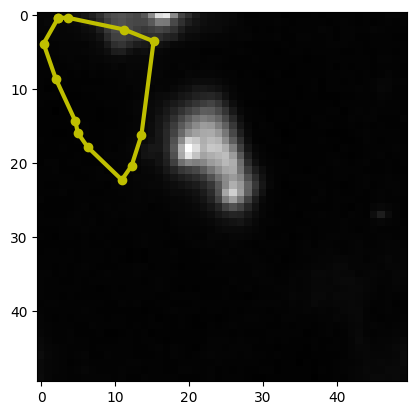

In [12]:
index = 0

cell_boundary = cell_boundaries[
    cell_boundaries["cell_id"] == cluster_A_cell_ids[index]
].copy()
img_A = cluster_A_images[index].convert("L")
img_A_resized = cluster_A_images_resized[index].convert("L")

# Calculate scaling factor
scaling_factor = 1 / 0.22
height, width = np.array(img_A).shape

# Calculate scaled x and y coordinates
cell_boundary["vertex_x_scaled"] = (
    (
        1
        + (
            (cell_boundary["vertex_x"] - cell_boundary["vertex_x"].min())
            * scaling_factor
        )
    )
    * 50
    / width
)
cell_boundary["vertex_y_scaled"] = (
    (
        1
        + (
            (cell_boundary["vertex_y"] - cell_boundary["vertex_y"].min())
            * scaling_factor
        )
    )
    * 50
    / height
)

# Visualize the image
plt.clf()
plt.close()
plt.imshow(img_A_resized, cmap='gray')
plt.plot(cell_boundary['vertex_x_scaled'], cell_boundary['vertex_y_scaled'], 'y-o', linewidth=3)
plt.show()

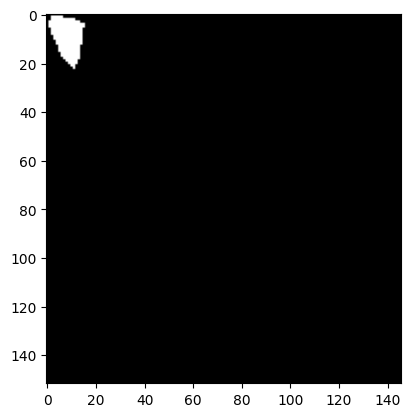

In [13]:
height, width = np.array(img_A.convert("L")).shape
polygon = np.array(
    list(zip(cell_boundary["vertex_y_scaled"], cell_boundary["vertex_x_scaled"]))
)
mask = polygon2mask((height, width), polygon)
masked_image = np.ma.masked_array(np.copy(img_A), np.invert(mask), fill_value=0)

# Display the masked image
# result = np.where(masked_image.mask, 0, masked_image)  # image with mask
result = np.where(masked_image.mask, 0, 1)  # just the mask
plt.imshow(result, cmap="gray")
plt.show()

### Masking all cells

In [14]:
def get_cluster_masked_images(cluster: int, size=(None, None), masked=False):
    images = get_cluster_images(cluster)
    if None not in size:  # get resized images if size is specified
        images_resized = get_cluster_images(cluster, size)

    cell_ids = get_cluster_cell_ids(cluster)
    cell_boundaries = cell_boundaries_raw.loc[
        cell_boundaries_raw["cell_id"].isin(cell_ids)
    ].copy()

    # Calculate scaling factor
    scaling_factor = 1 / 0.22

    result = {}
    for cell_id, image, image_resized in zip(cell_ids, images, images_resized):
        if masked:
            # get shape of original image (without resize)
            height, width = np.array(image).shape
            # scaling factor for cell boundary, only if size is given
            resize_x = 50 / width if None not in size else 1
            resize_y = 50 / height if None not in size else 1
    
            # get cell boundary coordinates for the image
            cell_boundary = cell_boundaries.loc[
                cell_boundaries["cell_id"] == cell_id
            ].copy()
            # Calculate scaled x and y coordinates
            cell_boundary["vertex_x_scaled"] = (
                1
                + (
                    (cell_boundary["vertex_x"] - cell_boundary["vertex_x"].min())
                    * scaling_factor
                )
            ) * resize_x
            cell_boundary["vertex_y_scaled"] = (
                1
                + (
                    (cell_boundary["vertex_y"] - cell_boundary["vertex_y"].min())
                    * scaling_factor
                )
            ) * resize_y
    
            # create the mask
            polygon = np.array(
                list(
                    zip(cell_boundary["vertex_y_scaled"], cell_boundary["vertex_x_scaled"])
                )
            )
            mask = polygon2mask((height, width) if None in size else SIZE, polygon)
            # mask the image
            masked_image = np.ma.masked_array(
                np.copy(image if None in size else image_resized),
                np.invert(mask),
                fill_value=0,
            )
            result[cell_id] = np.where(masked_image.mask, 0, masked_image)
        else:
            result[cell_id] = np.copy(image if None in size else image_resized)
 
    return result

In [15]:
masked_cells = {
    cluster: get_cluster_masked_images(cluster, size=SIZE, masked=True) for cluster in range(1, 29)
}

unmasked_cells = {
    cluster: get_cluster_masked_images(cluster, size=SIZE, masked=False) for cluster in range(1, 29)
}

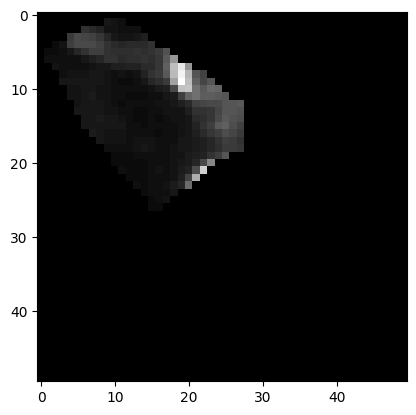

In [16]:
# display_images_in_grid(masked_cells[1])
cluster = 1
index = 3
plt.clf()
plt.close()
plt.imshow(masked_cells[cluster][list(unmasked_cells[cluster].keys())[index]], cmap="gray")
plt.show()

## Deep Learning

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

### Make the dataset

In [18]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np


class CustomDataset(Dataset):
    def __init__(self, images_dict, transform=None):
        self.images_dict = images_dict
        self.labels = []
        self.images = []
        for cluster, images in images_dict.items():
            self.images.extend(images.values())
            self.labels.extend([cluster - 1] * len(images))
        self.transform = transform  # Transformation to apply to each image
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # Convert image to PyTorch tensor and normalize if necessary
        image_tensor = torch.tensor(image, dtype=torch.float32) / 255.0
        image_tensor = torch.unsqueeze(image_tensor, 0)
        if self.transform:
            image_tensor = self.transform(image_tensor)  # Apply transformation
        # Convert label to PyTorch tensor
        label_tensor = torch.tensor(label, dtype=torch.long)
        return image_tensor, label_tensor


#### Load data and create dataloaders

In [32]:

from torchvision.transforms import AutoAugmentPolicy
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.AutoAugment(AutoAugmentPolicy.IMAGENET),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])
custom_dataset = CustomDataset(unmasked_cells,train_transforms)

# Define the sizes of the training, validation, and testing sets
train_size = int(0.6 * len(custom_dataset))  # 60% for training
val_size = int(0.2 * len(custom_dataset))  # 20% for validation
test_size = len(custom_dataset) - train_size - val_size  # Remaining for testing

# Split the dataset into training, validation, and testing sets
train_dataset, val_dataset, test_dataset = random_split(
    custom_dataset, [train_size, val_size, test_size]
)

# Define batch size and other DataLoader parameters
batch_size = 32
shuffle = True

# Create DataLoader for training set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

# Create DataLoader for validation set
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create DataLoader for testing set
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Make the models

#### Random simple model

In [20]:
class Model(nn.Module):
    def __init__(self, num_classes):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1
        )
        self.conv2 = nn.Conv2d(
            in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1
        )
        self.conv3 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1
        )
        self.fc1 = nn.Linear(
            64 * 6 * 6, 128
        )  # Adjust input size based on your image size
        self.fc2 = nn.Linear(128, num_classes)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)

        x = x.view(-1, 64 * 6 * 6)  # Adjust input size based on your image size
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### Lab 4b Model

In [21]:
class LabModel(nn.Module):
    def __init__(self):
        super(LabModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, padding=1
        )
        self.dropout1 = nn.Dropout2d(p=0.25)
        self.fc1 = nn.Linear(
            64 * 12 * 12, 128
        )  # Adjust input size based on your image size
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(64, 28)  # Assuming 2 classes for binary classification

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = x.view(-1, 64 * 12 * 12)  # Adjust input size based on your image size
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout2(x)
        x = nn.functional.relu(self.fc2(x))
        x = self.dropout3(x)
        x = self.fc3(x)
        return x

#### AlexNet

In [22]:
class AlexNet(nn.Module):
    def __init__(self, num=28):
        super(AlexNet, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 96, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=1),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(32 * 12 * 12, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num),
        )

    def forward(self, x):
        x = self.feature(x)
        x = x.view(-1, 32 * 12 * 12)
        return self.classifier(x)
        # return x

In [23]:

# Define the ResNet model
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F


class ModifiedResNet50(models.ResNet):
    def __init__(self, weights=None, num_classes=28, *args, **kwargs):
        super(ModifiedResNet50, self).__init__(
            block=models.resnet.Bottleneck, layers=[3, 4, 6, 3], *args, **kwargs
        )

        # Initialize a new fully connected layer with the correct number of classes
        self.fc = nn.Linear(2048, num_classes)

        # If weights is provided, load the state_dict with strict=False to avoid errors
        if weights is not None:
            state_dict = weights.state_dict()

            # Remove the weights related to the fully connected layer to avoid mismatch
            if 'fc.weight' in state_dict and 'fc.bias' in state_dict:
                del state_dict['fc.weight']
                del state_dict['fc.bias']

            self.load_state_dict(state_dict, strict=False)

        # Modify the first convolutional layer to accept 1-channel input
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Update the first layer's weights, if weights were provided
        if weights is not None:
            with torch.no_grad():
                original_first_layer = state_dict["conv1.weight"]
                self.conv1.weight.data = original_first_layer.mean(dim=1, keepdim=True)

        # Adding Dropout
        self.dropout = nn.Dropout(0.5)

        # Adding Batch Normalization
        self.bn1 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x




In [24]:
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a modified Vision Transformer (ViT) with a dropout layer
class ModifiedViT(nn.Module):
    def __init__(
        self,
        model_name="vit_base_patch16_224",
        pretrained=True,
        num_classes=1000,
        dropout_rate=0.3,  # Default dropout rate
    ):
        super(ModifiedViT, self).__init__()
        
        # Load the pretrained ViT model
        self.vit = timm.create_model(
            model_name, pretrained=pretrained, num_classes=num_classes
        )

        # Modify the patch embedding to handle grayscale images
        original_patch_embedding = self.vit.patch_embed.proj
        self.vit.patch_embed.proj = nn.Conv2d(
            1,
            original_patch_embedding.out_channels,
            kernel_size=original_patch_embedding.kernel_size,
            stride=original_patch_embedding.stride,
            padding=original_patch_embedding.padding,
            bias=False,
        )

        # If using pretrained weights, adjust for grayscale
        if pretrained:
            with torch.no_grad():
                original_weight = original_patch_embedding.weight.mean(
                    dim=1, keepdim=True
                )
                self.vit.patch_embed.proj.weight.data = original_weight

        # Add dropout layer after patch embedding
        self.dropout = nn.Dropout(p=dropout_rate)

        # Replace the classifier head
        self.vit.head = nn.Linear(self.vit.head.in_features, num_classes)

    def forward(self, x):
        x = self.vit.patch_embed(x)

        cls_token = self.vit.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        
        # Apply positional dropout and add positional embedding
        x = self.vit.pos_drop(x + self.vit.pos_embed)
        
        # Apply dropout before entering transformer blocks
        x = self.dropout(x)

        # Forward through the transformer blocks
        x = self.vit.blocks(x)
        
        # Apply normalization
        x = self.vit.norm(x)
        
        # Select CLS token and apply final dropout
        x = self.dropout(x[:, 0])
        
        # Final classifier head
        x = self.vit.head(x)

        return x


### Train

In [33]:
from tqdm import tqdm
import torch
import torch.nn as nn

def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.001,save_path=None):
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Move the model to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.clear_autocast_cache()
    model.to(device)

    # Store training and validation loss and accuracy
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Progress bar for inner training loop
        with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False) as pbar:
            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass and backward pass with optimization
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # Accumulate loss and accuracy
                running_train_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

                # Update the progress bar with training loss and accuracy
                pbar.set_postfix({
                    "train_loss": running_train_loss / total_train,
                    "accuracy": correct_train / total_train,
                })

        # Calculate average training loss and accuracy for the epoch
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        epoch_train_accuracy = correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # Validation loop
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Accumulate loss and accuracy
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        # Calculate average validation loss and accuracy
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_accuracy = correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)
        
        # Save the model state
        if save_path:
            model_save_path = os.path.join(save_path, f"model_epoch_{epoch + 1}.pth")
            torch.save(model.state_dict(), model_save_path)

        # Optional: Print a summary at the end of each epoch
        print(
            f"Epoch [{epoch + 1}/{num_epochs}], "
            f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}, "
            f"Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}"
        )

    # Return training and validation losses and accuracies
    return train_losses, val_losses, train_accuracies, val_accuracies


In [34]:
for images, labels in train_loader:
    print(images.size())
    break

torch.Size([32, 1, 50, 50])


In [35]:
save_path = os.path.join(script_dir, "models")
model = ModifiedResNet50()
t_loss, v_loss, t_acc, v_acc = train_model(model, train_loader, val_loader,num_epochs=100,save_path=save_path)
lab_model_results = {"t_loss": t_loss, "v_loss": v_loss, "t_acc": t_acc, "v_acc": v_acc}

Epoch [1/100], Train Loss: 3.1965, Train Accuracy: 0.0976, Val Loss: 3.1460, Val Accuracy: 0.1056


Epoch [2/100], Train Loss: 3.1179, Train Accuracy: 0.0994, Val Loss: 3.1118, Val Accuracy: 0.1089


Epoch [3/100], Train Loss: 3.0958, Train Accuracy: 0.1040, Val Loss: 3.1062, Val Accuracy: 0.1038


Epoch [4/100], Train Loss: 3.0848, Train Accuracy: 0.1035, Val Loss: 3.0700, Val Accuracy: 0.1070


Epoch [5/100], Train Loss: 3.0619, Train Accuracy: 0.1113, Val Loss: 3.0663, Val Accuracy: 0.1082


Epoch [6/100], Train Loss: 3.0688, Train Accuracy: 0.1042, Val Loss: 3.0872, Val Accuracy: 0.1068


Epoch [7/100], Train Loss: 3.0586, Train Accuracy: 0.1104, Val Loss: 3.0598, Val Accuracy: 0.1062


Epoch [8/100], Train Loss: 3.0551, Train Accuracy: 0.1102, Val Loss: 3.0746, Val Accuracy: 0.1038


Epoch [9/100], Train Loss: 3.0567, Train Accuracy: 0.1085, Val Loss: 3.0638, Val Accuracy: 0.0997


Epoch [10/100], Train Loss: 3.0502, Train Accuracy: 0.1094, Val Loss: 3.0548, Val Accuracy: 0.1126


Epoch [11/100], Train Loss: 3.0466, Train Accuracy: 0.1129, Val Loss: 3.0535, Val Accuracy: 0.1041


Epoch [12/100], Train Loss: 3.0476, Train Accuracy: 0.1137, Val Loss: 3.0483, Val Accuracy: 0.1142


Epoch [13/100], Train Loss: 3.0423, Train Accuracy: 0.1123, Val Loss: 3.0519, Val Accuracy: 0.1079


Epoch [14/100], Train Loss: 3.0449, Train Accuracy: 0.1131, Val Loss: 3.0628, Val Accuracy: 0.1098


Epoch [15/100], Train Loss: 3.0472, Train Accuracy: 0.1122, Val Loss: 3.0520, Val Accuracy: 0.1086


Epoch [16/100], Train Loss: 3.0420, Train Accuracy: 0.1155, Val Loss: 3.0515, Val Accuracy: 0.1071


Epoch [17/100], Train Loss: 3.0377, Train Accuracy: 0.1162, Val Loss: 3.0478, Val Accuracy: 0.1119


Epoch [18/100], Train Loss: 3.0355, Train Accuracy: 0.1171, Val Loss: 3.0398, Val Accuracy: 0.1181


Epoch [19/100], Train Loss: 3.0352, Train Accuracy: 0.1141, Val Loss: 3.0409, Val Accuracy: 0.1129


Epoch [20/100], Train Loss: 3.0295, Train Accuracy: 0.1222, Val Loss: 3.0264, Val Accuracy: 0.1174


Epoch [21/100], Train Loss: 3.0266, Train Accuracy: 0.1238, Val Loss: 3.0439, Val Accuracy: 0.1200


Epoch [22/100], Train Loss: 3.0197, Train Accuracy: 0.1269, Val Loss: 3.0207, Val Accuracy: 0.1294


Epoch [23/100], Train Loss: 3.0139, Train Accuracy: 0.1286, Val Loss: 3.0162, Val Accuracy: 0.1244


Epoch [24/100], Train Loss: 3.0074, Train Accuracy: 0.1337, Val Loss: 3.0155, Val Accuracy: 0.1283


Epoch [25/100], Train Loss: 2.9984, Train Accuracy: 0.1346, Val Loss: 3.0105, Val Accuracy: 0.1245


Epoch [26/100], Train Loss: 2.9990, Train Accuracy: 0.1344, Val Loss: 2.9960, Val Accuracy: 0.1315


Epoch [27/100], Train Loss: 2.9917, Train Accuracy: 0.1366, Val Loss: 2.9891, Val Accuracy: 0.1363


Epoch [28/100], Train Loss: 2.9790, Train Accuracy: 0.1409, Val Loss: 2.9841, Val Accuracy: 0.1383


Epoch [29/100], Train Loss: 2.9750, Train Accuracy: 0.1422, Val Loss: 2.9815, Val Accuracy: 0.1349


Epoch [30/100], Train Loss: 2.9658, Train Accuracy: 0.1445, Val Loss: 2.9808, Val Accuracy: 0.1401


Epoch [31/100], Train Loss: 2.9600, Train Accuracy: 0.1461, Val Loss: 2.9753, Val Accuracy: 0.1428


Epoch [32/100], Train Loss: 2.9557, Train Accuracy: 0.1481, Val Loss: 2.9640, Val Accuracy: 0.1412


Epoch [33/100], Train Loss: 2.9545, Train Accuracy: 0.1470, Val Loss: 2.9704, Val Accuracy: 0.1369


Epoch [34/100], Train Loss: 2.9524, Train Accuracy: 0.1477, Val Loss: 2.9640, Val Accuracy: 0.1436


Epoch [35/100], Train Loss: 2.9448, Train Accuracy: 0.1495, Val Loss: 2.9694, Val Accuracy: 0.1445


Epoch [36/100], Train Loss: 2.9424, Train Accuracy: 0.1516, Val Loss: 2.9528, Val Accuracy: 0.1486


Epoch [37/100], Train Loss: 2.9463, Train Accuracy: 0.1477, Val Loss: 2.9523, Val Accuracy: 0.1451


Epoch [38/100], Train Loss: 2.9382, Train Accuracy: 0.1502, Val Loss: 2.9474, Val Accuracy: 0.1451


Epoch [39/100], Train Loss: 2.9374, Train Accuracy: 0.1504, Val Loss: 2.9524, Val Accuracy: 0.1451


Epoch [40/100], Train Loss: 2.9337, Train Accuracy: 0.1516, Val Loss: 2.9566, Val Accuracy: 0.1425


Epoch [41/100], Train Loss: 2.9310, Train Accuracy: 0.1513, Val Loss: 2.9530, Val Accuracy: 0.1447


Epoch [42/100], Train Loss: 2.9265, Train Accuracy: 0.1533, Val Loss: 2.9600, Val Accuracy: 0.1456


Epoch [43/100], Train Loss: 2.9253, Train Accuracy: 0.1538, Val Loss: 2.9433, Val Accuracy: 0.1460


Epoch [44/100], Train Loss: 2.9216, Train Accuracy: 0.1536, Val Loss: 2.9609, Val Accuracy: 0.1391


Epoch [45/100], Train Loss: 2.9239, Train Accuracy: 0.1534, Val Loss: 2.9487, Val Accuracy: 0.1503


Epoch [46/100], Train Loss: 2.9198, Train Accuracy: 0.1555, Val Loss: 2.9493, Val Accuracy: 0.1446


Epoch [47/100], Train Loss: 2.9150, Train Accuracy: 0.1563, Val Loss: 2.9352, Val Accuracy: 0.1510


Epoch [48/100], Train Loss: 2.9110, Train Accuracy: 0.1554, Val Loss: 2.9356, Val Accuracy: 0.1542


Epoch [49/100], Train Loss: 2.9100, Train Accuracy: 0.1553, Val Loss: 2.9369, Val Accuracy: 0.1534


Epoch [50/100], Train Loss: 2.9100, Train Accuracy: 0.1551, Val Loss: 2.9289, Val Accuracy: 0.1494


Epoch [51/100], Train Loss: 2.9106, Train Accuracy: 0.1539, Val Loss: 2.9365, Val Accuracy: 0.1520


Epoch [52/100], Train Loss: 2.9050, Train Accuracy: 0.1600, Val Loss: 2.9528, Val Accuracy: 0.1503


Epoch [53/100], Train Loss: 2.9041, Train Accuracy: 0.1594, Val Loss: 2.9431, Val Accuracy: 0.1462


Epoch [54/100], Train Loss: 2.9115, Train Accuracy: 0.1569, Val Loss: 2.9465, Val Accuracy: 0.1425


Epoch [55/100], Train Loss: 2.9021, Train Accuracy: 0.1615, Val Loss: 2.9288, Val Accuracy: 0.1525


Epoch [56/100], Train Loss: 2.9002, Train Accuracy: 0.1562, Val Loss: 2.9341, Val Accuracy: 0.1523


Epoch [57/100], Train Loss: 2.8946, Train Accuracy: 0.1589, Val Loss: 2.9310, Val Accuracy: 0.1501


Epoch [58/100], Train Loss: 2.8916, Train Accuracy: 0.1608, Val Loss: 2.9314, Val Accuracy: 0.1521


Epoch [59/100], Train Loss: 2.8942, Train Accuracy: 0.1582, Val Loss: 2.9230, Val Accuracy: 0.1542


Epoch [60/100], Train Loss: 2.8883, Train Accuracy: 0.1626, Val Loss: 2.9290, Val Accuracy: 0.1486


Epoch [61/100], Train Loss: 2.8818, Train Accuracy: 0.1646, Val Loss: 2.9258, Val Accuracy: 0.1550


Epoch [62/100], Train Loss: 2.8810, Train Accuracy: 0.1603, Val Loss: 2.9250, Val Accuracy: 0.1529


Epoch [63/100], Train Loss: 2.8783, Train Accuracy: 0.1656, Val Loss: 2.9175, Val Accuracy: 0.1566


Epoch [64/100], Train Loss: 2.8778, Train Accuracy: 0.1634, Val Loss: 2.9176, Val Accuracy: 0.1546


Epoch [65/100], Train Loss: 2.8756, Train Accuracy: 0.1651, Val Loss: 2.9241, Val Accuracy: 0.1544


Epoch [66/100], Train Loss: 2.8742, Train Accuracy: 0.1637, Val Loss: 2.9191, Val Accuracy: 0.1550


Epoch [67/100], Train Loss: 2.8716, Train Accuracy: 0.1654, Val Loss: 2.9196, Val Accuracy: 0.1596


Epoch [68/100], Train Loss: 2.8719, Train Accuracy: 0.1663, Val Loss: 2.9274, Val Accuracy: 0.1512


Epoch [69/100], Train Loss: 2.8684, Train Accuracy: 0.1654, Val Loss: 2.9270, Val Accuracy: 0.1546


Epoch [70/100], Train Loss: 2.8635, Train Accuracy: 0.1668, Val Loss: 2.9216, Val Accuracy: 0.1568


Epoch [71/100], Train Loss: 2.8642, Train Accuracy: 0.1650, Val Loss: 2.9180, Val Accuracy: 0.1579


Epoch [72/100], Train Loss: 2.8591, Train Accuracy: 0.1692, Val Loss: 2.9178, Val Accuracy: 0.1590


Epoch [73/100], Train Loss: 2.8564, Train Accuracy: 0.1689, Val Loss: 2.9225, Val Accuracy: 0.1538


Epoch [74/100], Train Loss: 2.8534, Train Accuracy: 0.1683, Val Loss: 2.9363, Val Accuracy: 0.1514


Epoch [75/100], Train Loss: 2.8512, Train Accuracy: 0.1707, Val Loss: 2.9215, Val Accuracy: 0.1557


Epoch [76/100], Train Loss: 2.8502, Train Accuracy: 0.1668, Val Loss: 2.9178, Val Accuracy: 0.1540


Epoch [77/100], Train Loss: 2.8428, Train Accuracy: 0.1704, Val Loss: 2.9197, Val Accuracy: 0.1568


Epoch [78/100], Train Loss: 2.8402, Train Accuracy: 0.1701, Val Loss: 2.9270, Val Accuracy: 0.1514


Epoch [79/100], Train Loss: 2.8402, Train Accuracy: 0.1711, Val Loss: 2.9254, Val Accuracy: 0.1535


Epoch [80/100], Train Loss: 2.8309, Train Accuracy: 0.1744, Val Loss: 2.9200, Val Accuracy: 0.1624


Epoch [81/100], Train Loss: 2.8364, Train Accuracy: 0.1734, Val Loss: 2.9193, Val Accuracy: 0.1540


Epoch [82/100], Train Loss: 2.8270, Train Accuracy: 0.1761, Val Loss: 2.9247, Val Accuracy: 0.1506


Epoch [83/100], Train Loss: 2.8232, Train Accuracy: 0.1763, Val Loss: 2.9392, Val Accuracy: 0.1553


Epoch [84/100], Train Loss: 2.8229, Train Accuracy: 0.1761, Val Loss: 2.9365, Val Accuracy: 0.1521


Epoch [85/100], Train Loss: 2.8216, Train Accuracy: 0.1753, Val Loss: 2.9191, Val Accuracy: 0.1546


Epoch [86/100], Train Loss: 2.8148, Train Accuracy: 0.1770, Val Loss: 2.9361, Val Accuracy: 0.1577


Epoch [87/100], Train Loss: 2.8088, Train Accuracy: 0.1800, Val Loss: 2.9311, Val Accuracy: 0.1640


Epoch [88/100], Train Loss: 2.8032, Train Accuracy: 0.1835, Val Loss: 2.9254, Val Accuracy: 0.1536


Epoch [89/100], Train Loss: 2.8006, Train Accuracy: 0.1811, Val Loss: 2.9465, Val Accuracy: 0.1554


Epoch [90/100], Train Loss: 2.8175, Train Accuracy: 0.1795, Val Loss: 2.9481, Val Accuracy: 0.1536


Epoch [91/100], Train Loss: 2.7988, Train Accuracy: 0.1800, Val Loss: 2.9433, Val Accuracy: 0.1543


Epoch [92/100], Train Loss: 2.7861, Train Accuracy: 0.1851, Val Loss: 2.9395, Val Accuracy: 0.1516


Epoch [93/100], Train Loss: 2.7781, Train Accuracy: 0.1864, Val Loss: 2.9464, Val Accuracy: 0.1550


Epoch [94/100], Train Loss: 2.7727, Train Accuracy: 0.1875, Val Loss: 2.9323, Val Accuracy: 0.1534


Epoch [95/100], Train Loss: 2.7681, Train Accuracy: 0.1909, Val Loss: 2.9420, Val Accuracy: 0.1543


Epoch [96/100], Train Loss: 2.7615, Train Accuracy: 0.1926, Val Loss: 2.9644, Val Accuracy: 0.1546


Epoch [97/100], Train Loss: 2.7735, Train Accuracy: 0.1885, Val Loss: 2.9612, Val Accuracy: 0.1518


Epoch [98/100], Train Loss: 2.7533, Train Accuracy: 0.1928, Val Loss: 2.9599, Val Accuracy: 0.1570


Epoch [99/100], Train Loss: 2.7328, Train Accuracy: 0.1977, Val Loss: 2.9437, Val Accuracy: 0.1539


Epoch [100/100], Train Loss: 2.7237, Train Accuracy: 0.2019, Val Loss: 2.9838, Val Accuracy: 0.1466


In [37]:
def generate_plots(train_losses, val_losses, train_accuracies, val_accuracies):
    with plt.style.context("dark_background"):
        # Generate x-axis values (epochs)
        epochs = range(1, len(train_losses) + 1)

        # Create subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

        # Plot training and validation losses
        ax1.plot(epochs, train_losses, label="Training Loss", marker="o")
        ax1.plot(epochs, val_losses, label="Validation Loss", marker="o")

        # Add jitter to the data points for better visualization
        ax1.scatter(epochs, train_losses, color="blue")
        ax1.scatter(epochs, val_losses, color="orange")

        # Add labels and legend for the first subplot
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Loss")
        ax1.set_title("Training and Validation Loss")
        ax1.legend()

        # Plot training and validation accuracies
        ax2.plot(epochs, train_accuracies, label="Training Accuracy", marker="o")
        ax2.plot(epochs, val_accuracies, label="Validation Accuracy", marker="o")

        # Add jitter to the data points for better visualization
        ax2.scatter(epochs, train_accuracies, color="green")
        ax2.scatter(epochs, val_accuracies, color="red")

        # Add labels and legend for the second subplot
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("Accuracy")
        ax2.set_title("Training and Validation Accuracy")
        ax2.legend()

        # Adjust layout
        plt.tight_layout()

        # Show plot
        plt.show()

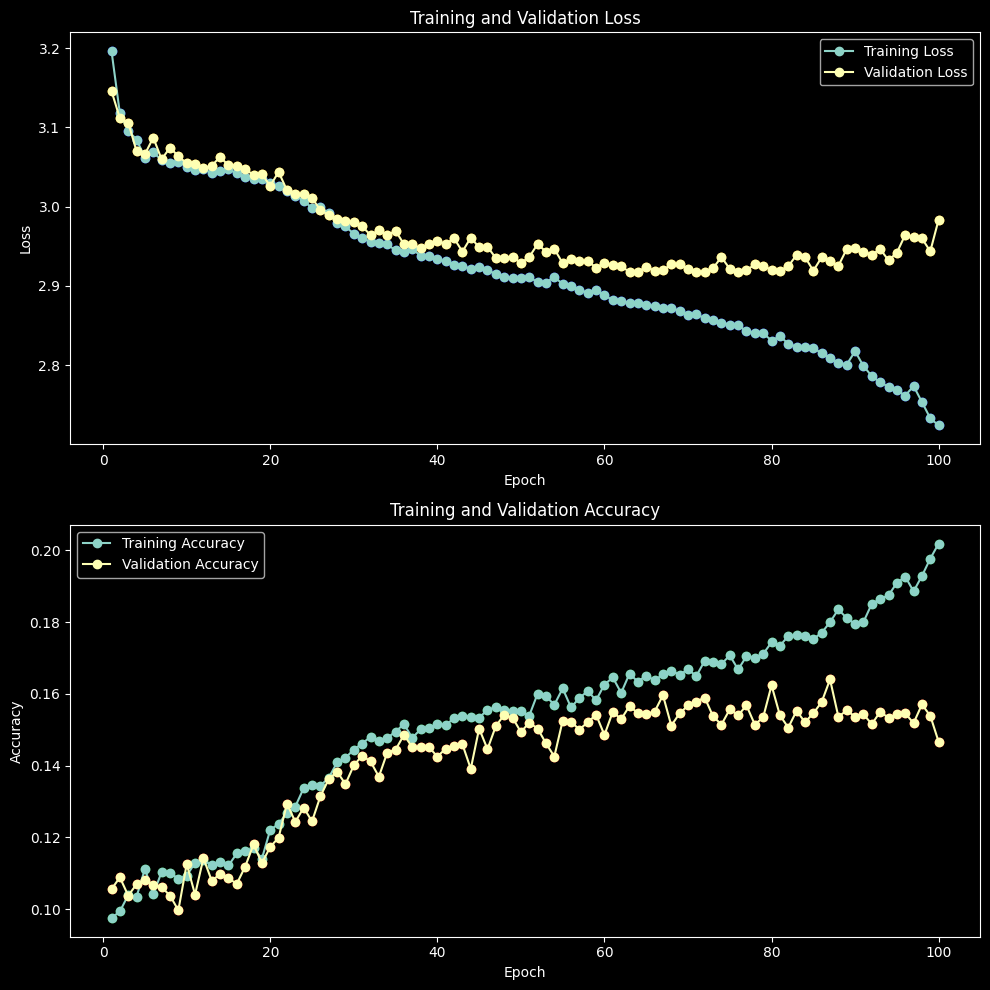

In [38]:
generate_plots(lab_model_results['t_loss'], lab_model_results['v_loss'], lab_model_results['t_acc'], lab_model_results['v_acc'])